# Seattle cloud aerosol-cloud μ-physics modelling mini-workshop 2026

## Part 2: SDM collisional growth Monte-Carlo algorithm in a box model 

### • sampling a particle population

In [1]:
import numpy as np
from scipy import stats

def sample(*,
    rng: np.random.Generator,
    dist: stats.rv_continuous,
    norm: float,
    n_s: int,
):
    state = np.empty(
        shape=n_s,
        dtype=[('ξ', np.int64), ('m', np.float64)]
    )
    state['ξ'] =  round(norm / n_s)
    state['m'] =  dist.ppf(rng.uniform(0, 1, n_s))
    return state

### • SDM Monte-Carlo algorithm

In [2]:
from collections import abc

def sdm(*,
    rng: np.random.Generator,
    ξ: abc.MutableSequence[int],
    m: abc.MutableSequence[float],
    kern: abc.Callable[[float, float], float],
    Δt: float,
    Δv: float,
):
    """ SDM step assuming non-zero multiplicities """
    n_s = len(ξ)
    n_pair = n_s // 2

    pairs = rng.permutation(n_s)[: 2 * n_pair]
    φ = rng.uniform(0, 1, n_pair)

    p_ratio = n_s * (n_s - 1) / 2 / n_pair
    for α, (j, k) in enumerate(pairs.reshape(-1, 2)):
        p_jk = kern(m[j], m[k]) * Δt / Δv
        if ξ[j] < ξ[k]:
            j, k = k, j
        p_α = ξ[j] * p_ratio * p_jk
        γ = p_α // 1 + (p_α - p_α // 1) > φ[α]
        if γ != 0:
            γ = min(γ, (ξ[j] / ξ[k]) // 1)
            if ξ[j] - γ * ξ[k] > 0:
                ξ[j] -= γ * ξ[k]
                m[k] += γ * m[j]
            else:
                ξ[j] = ξ[k] // 2
                ξ[k] -= ξ[j]
                m[k] += γ * m[j]
                m[j] = m[k]



### • additive kernel

In [3]:
def additive_kernel(mass_1, mass_2, coeff):
    """ additive coagulation kernel """
    return coeff * (mass_1 + mass_2)

### • simulation parameters

In [4]:
from types import SimpleNamespace

PARAMS_PHYS = SimpleNamespace(
    n0 = 2**23,
    Δv = 1e6,
    b = 1.5e3,
)
PARAMS_PHYS.norm = PARAMS_PHYS.n0 * PARAMS_PHYS.Δv
PARAMS_PHYS.dist = stats.expon(loc=0, scale=1 / PARAMS_PHYS.norm)

PARAMS_COMP = SimpleNamespace(
    n_drop = 2**11,
    Δt = 1,
    n_step = 3600,
    output_step = 100,
)

PARAMS_PLOT = SimpleNamespace(
    x_of_mass = lambda mass: np.log(mass) / 3,
    mass_of_x = lambda x: np.exp(3 * x),
    bins_x_range = (-12, -5),
    bins_count = 35,
)

RNG = np.random.default_rng(seed=123)

### • simulation (i.e. time-stepping loop and output storage)

In [5]:
from functools import partial
from copy import deepcopy

def simulate(*, params_phys, params_comp, rng):
    """ does simulation for all sampling variants (each variant using the same shuffled numbers) """
    particles = sample(
        dist=params_phys.dist,
        norm=params_phys.norm,
        n_s=params_comp.n_drop,
        rng=rng,
    )
    kern = partial(additive_kernel, coeff=params_phys.b)
    output = []
    for step in range(params_comp.n_step + 1):
        if step != 0:
            sdm(
                rng=rng,
                kern=kern,
                Δt=params_comp.Δt,
                Δv=params_phys.Δv,
                m=particles['m'],
                ξ=particles['ξ'],
            )
        output += [deepcopy(particles) if step % params_comp.output_step == 0 else None]
    return output
OUTPUT = simulate(params_phys=PARAMS_PHYS, params_comp=PARAMS_COMP, rng=RNG)

### • Safranov/Golovin analytic solution

In [6]:
from scipy import special

def analytic_solution(mass, time, x0, b, n0):
    """ [Safranov's analytic solution](https://www.mathnet.ru/rus/dan27172)
    to Smoluchowski coagulation equation for additive kernel
    and exponential initial condition """
    tau = 1 - np.exp(-n0 * x0 * b * time)
    sqrt_tau = np.sqrt(tau)
    return (
        (1 - tau) / (mass * sqrt_tau)
        * special.ive(1, 2 * mass / x0 * sqrt_tau)  # pylint: disable=no-member
        * np.exp(-(1 + tau - 2 * sqrt_tau) * mass / x0)
    )

### • animated visualisation


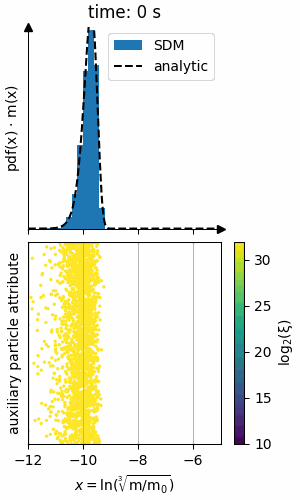

HTML(value="<a href='./tmptamcnxmr.gif' target='_blank'>./tmptamcnxmr.gif</a><br>")

In [7]:
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_anim

def plot(step, *, output, params_phys, params_comp, params_plot, positions):
    """ plots the particle state as both a histogram as well as population scatter plot
    (with random coordinates shuffled for the purpose of plotting) """
    time = 1e-10 if step == 0 else step * params_comp.Δt
    hist_axis_max = 1.5
    particles = output[step]

    fig, axs = pyplot.subplot_mosaic(
        [['hist'], ['part']],
        figsize=(3, 5),
        sharex=True,
        layout='constrained',
    )
    points = axs['part'].scatter(
        params_plot.x_of_mass(particles['m']),
        positions,
        c=np.log2(particles['ξ']),
        s=2
    )
    points.set_clim(10, np.log2(params_phys.norm / params_comp.n_drop))

    analytic_mass_dist = lambda mass, x: mass * params_phys.norm * analytic_solution(
        mass=mass,
        time=time,
        x0=1/params_phys.norm,
        n0=params_phys.n0,
        b=params_phys.b
    ) * np.diff(params_plot.mass_of_x(x)) / np.diff(x)

    hist_y, hist_x, _ = axs['hist'].hist(
        x=params_plot.x_of_mass(particles['m']),
        weights=particles['ξ'] / params_phys.norm * particles['m'],
        bins=params_plot.bins_count,
        range=params_plot.bins_x_range,
        label="SDM",
        density=True,
    )

    lin_x, d_x = np.linspace(*params_plot.bins_x_range, 256, retstep=True)
    x_mean = lin_x[:-1] + d_x / 2
    axs['hist'].plot(
        x_mean,
        analytic_mass_dist(params_plot.mass_of_x(x_mean), lin_x),
        color='black',
        label='analytic',
        ls='--'
    )

    axs['hist'].legend()
    axs['hist'].set(
        ylim=(0, hist_axis_max),
        yticks=[],
        ylabel=r'pdf(x) $\cdot$ m(x)',
        title=f'time: {time:.0f} s',
        xlim=params_plot.bins_x_range
    )
    for loc in ('top', 'right'):
        axs['hist'].spines[loc].set_visible(False)
    axs['hist'].plot(1, 0, ">k", transform=axs['hist'].get_yaxis_transform(), clip_on=False)
    axs['hist'].plot(params_plot.bins_x_range[0], 1.5, "^k", clip_on=False)
    axs['part'].set(
        xlabel=r'$x = \ln(\sqrt[3]{\text{m/m}_0})$',
        ylabel='auxiliary particle attribute',
        yticks=[],
        ylim=(0, 1)
    )
    axs['part'].grid()
    fig.colorbar(points, label='log$_2$(ξ)')
    pyplot.savefig(f"{step:04d}.pdf")
    return fig

show_anim(
    partial(
        plot,
        output=OUTPUT,
        params_phys=PARAMS_PHYS,
        params_comp=PARAMS_COMP,
        params_plot=PARAMS_PLOT,
        positions=RNG.uniform(0, 1, PARAMS_COMP.n_drop),
    ),
    frame_range=range(0, len(OUTPUT), PARAMS_COMP.output_step),
)